In [1]:
import numpy as np
import pandas as pd
import os


/kaggle/input/word2vec-for-text-summarization/__results__.html
/kaggle/input/word2vec-for-text-summarization/__notebook__.ipynb
/kaggle/input/word2vec-for-text-summarization/__output__.json
/kaggle/input/word2vec-for-text-summarization/w2v_text_summ_200d_09162019
/kaggle/input/word2vec-for-text-summarization/custom.css
/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv
/kaggle/input/inshorts-news-data/Inshorts Cleaned Data.xlsx


In [2]:
pre = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx')

In [3]:
pre.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
pre.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [6]:
pre.head(2)

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...


In [7]:
pre['Headline'][:10]

0    4 ex-bank officials booked for cheating bank o...
1       Supreme Court to go paperless in 6 months: CJI
2    At least 3 killed, 30 injured in blast in Sylh...
3    Why has Reliance been barred from trading in f...
4    Was stopped from entering my own studio at Tim...
5     New trailer of &#39;Justice League&#39; released
6    His touch was not right: Shilpa Shinde on sexu...
7    Anti-Romeo squads must not trouble consenting ...
8    Both Romeo and Juliet are welcome in Delhi: AA...
9    30 blasts occur at ordnance factory in MP,  20...
Name: Headline, dtype: object

> **Perform Data Cleansing**

In [8]:
import re

def text_strip(column):
    for row in column:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        yield row




In [9]:
brief_cleaning1 = text_strip(pre['Short'])
brief_cleaning2 = text_strip(pre['Headline'])

In [10]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.75 mins


In [11]:
t = time()

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.23 mins


In [12]:
text[0]

'the cbi on saturday booked four former officials of syndicate bank and six others for cheating forgery criminal conspiracy and causing ₹209 crore loss to the state-run bank the accused had availed home loans and credit from syndicate bank on the basis of forged and fabricated documents these funds were fraudulently transferred to the companies owned by the accused persons.'

In [13]:
summary[0]

'_START_ 4 ex-bank officials booked for cheating bank of ₹209 crore _END_'

In [14]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [15]:
text_count = []
summary_count = []

In [16]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [17]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

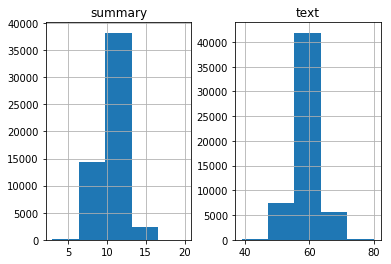

In [18]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [19]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9970419570267132


In [20]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

1.0


In [21]:
max_text_len=100
max_summary_len=20

In [22]:
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [23]:
post_pre.head(2)

,text,summary
0,the cbi on saturday booked four former officia...,_START_ 4 ex-bank officials booked for cheatin...
1,chief justice js khehar has said the supreme c...,_START_ supreme court to go paperless in month...


In [24]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [25]:
post_pre.head(2)

,text,summary
0,the cbi on saturday booked four former officia...,sostok _START_ 4 ex-bank officials booked for ...
1,chief justice js khehar has said the supreme c...,sostok _START_ supreme court to go paperless i...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [26]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)
x_tr,x_test,y_tr,y_test=train_test_split(x_tr, y_tr, test_size=0.1,random_state=0,shuffle=True)

In [27]:
y_tr[:10]

array(['sostok _START_ new poster of emma watson #39 #39 beauty and the beast #39 out _END_ eostok',
       'sostok _START_ microsoft donated ₹1.6 crore to trump inauguration report _END_ eostok',
       'sostok _START_ kejriwal learns punjabi ahead of punjab polls _END_ eostok',
       'sostok _START_ banks refusing to exchange soiled notes to be fined ₹10 000 _END_ eostok',
       'sostok _START_ vaani kapoor features on dec cover of vogue india _END_ eostok',
       'sostok _START_ union cabinet approves new power tariff policy _END_ eostok',
       'sostok _START_ censor board has denied certificate to mohalla assi pahlaj _END_ eostok',
       'sostok _START_ pataudi is the only cricketer to play for india and england _END_ eostok',
       'sostok _START_ man who put fake #39 churan lable #39 ₹2 000 notes in atm arrested _END_ eostok',
       'sostok _START_ euro zone releases another $3 billion loan to greece _END_ eostok'],
      dtype=object)

In [28]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Using TensorFlow backend.


In [29]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.52182461082501
Total Coverage of rare words: 2.2981886188938017


In [30]:

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)


x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test   =   pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')


x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 25545


In [31]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [32]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.02376586224602
Total Coverage of rare words: 6.240878534047925


In [33]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 7629


In [34]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [35]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [36]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

#encoder lstm 4
encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output3)


decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 25545
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     5109000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100, 300), ( 721200      lstm[0][0]                       
________________________________________________

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=100 ,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 44633 samples, validate on 5511 samples
Epoch 1/100
44633/44633 [==============================] - 82s 2ms/sample - loss: 3.7998 - val_loss: 3.1993
Epoch 2/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 3.1582 - val_loss: 3.0601
Epoch 3/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 3.0552 - val_loss: 2.9901
Epoch 4/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 2.9815 - val_loss: 2.9244
Epoch 5/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 2.9104 - val_loss: 2.8645
Epoch 6/100
44633/44633 [==============================] - 71s 2ms/sample - loss: 2.8457 - val_loss: 2.8162
Epoch 7/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 2.7828 - val_loss: 2.7696
Epoch 8/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 2.7253 - val_loss: 2.7222
Epoch 9/100
44633/44633 [==============================] - 70s 2ms/sample - loss: 2.671

In [40]:
model.save("nlp_100_weights.h5py")

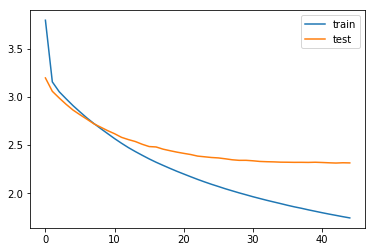

In [41]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [42]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [43]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [44]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [45]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [46]:
for i in range(0,100):
    print(f"{i}")
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

0
Review: a new poster of the emma watson starrer upcoming romantic fantasy musical film 39 beauty and the beast 39 has been released the film is live action adaptation of disney 39 animated classic directed by bill condon the film also stars dan stevens as 39 the beast 39 and is scheduled to release on march 17 2017 
Original summary: start new poster of emma watson 39 39 beauty and the beast 39 out end 
Predicted summary:  start new trailer of 39 39 released end


1
Review: according to report by american organisation politico companies like amazon and google made donations to us president donald trump 39 inauguration with microsoft contributing ₹1 6 crore 250 000 in cash microsoft is now part of the legal brief filed by nearly 100 companies to support an ongoing lawsuit against trump 39 immigration ban tesla and facebook are also part of the brief 
Original summary: start microsoft ₹1 6 crore to trump inauguration report end 
Predicted summary:  start google search for 39 39 in us e

In [47]:
print(len(x_test))
y_pred = []
for i in range(50):
    print(f"{i}")
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    y_pred.append(decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("Predicted summary:",y_pred[-1])
    print("\n")

4960
0
Review: the university of colorado girls 39 football team scored goal against hawaii following front flip throw in in the third minute from university of colorado 39 evans evans 39 throw in reached the opponent 39 penalty box where her teammate taylor scored with header into the far post the university of colorado team went on to win the match 3 1 
Original summary: start team scores goal from throw in end 
Predicted summary:  start 39 39 most searched on zomato end


1
Review: state run oil and natural gas corporation ongc has received clearance from the environment ministry for ₹53 000 crore project in andhra pradesh 39 krishna godavari basin under the project ongc will dig 45 development wells and build other related infrastructure the project is expected to produce 51 33 billion cubic meters of gas and 26 71 million cubic meters of oil 
Original summary: start ongc gets approval for cr project in andhra end 
Predicted summary:  start india 39 largest import of oil cos up by 

In [48]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_text_len)).split(" ")]
    return corpus_bleu(references, candidates)

from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(25):
    scores.append(BLEU_Score(y_test[i],x_test[i]))
    
print(np.mean(scores))

0.6016654080823338
